In [1]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
from simpegem1d import DigFilter
%matplotlib inline
import matplotlib 
matplotlib.rcParams["font.size"] = 14

In [2]:
# eta, tau, c = 0.1, 0.01, 0.5
cs, ncx, ncz, npad = 10., 25, 20, 18
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sigmaInf = np.ones(mesh.nC) * 0.001
airind = mesh.gridCC[:,2]>0.
actinds = ~airind
layerind = (np.logical_and(mesh.gridCC[:,2]<-150, mesh.gridCC[:,2]>-400.)) & (mesh.gridCC[:,0]<100.)
sigmaInf[airind] = 1e-8
sigmaInf[layerind] = 0.1
eta = np.zeros(mesh.nC)
eta[layerind] = 0.5
tau = np.ones(mesh.nC) * 0.005
c = np.ones(mesh.nC) * 1.

actmapeta = Maps.InjectActiveCells(mesh, actinds, 0.)
actmaptau = Maps.InjectActiveCells(mesh, actinds, 0.005)
actmapc = Maps.InjectActiveCells(mesh, actinds, 1.)

wires = Maps.Wires(('eta', actmapeta.nP), ('tau', actmapeta.nP), ('c', actmapeta.nP))

taumap = actmaptau*wires.tau
etamap = actmapeta*wires.eta
cmap = actmapc*wires.c

m = np.r_[eta[actinds], tau[actinds], c[actinds]]

In [27]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-4), np.log10(0.01), 41), 'z')
src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
survey = EM.TDEM.Survey([src])
prb_em = EM.TDEM.Problem3D_e(mesh, sigmaMap=Maps.IdentityMap(mesh))
prb_em.timeSteps = [(1e-5, 5),(5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 20)]
prb_em.Solver = PardisoSolver
prb_em.pair(survey)
F = prb_em.fields(sigmaInf)
data_em = survey.dpred(sigmaInf, f=F)


In [28]:
from simpegEMIP.TDEM import geteref, Problem3D_Inductive, Survey, getwe, get_we_eff

In [29]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])
dt = 1e-6
survey_ip = Survey([src])
e = F[:, 'eSolution', :]
eref = geteref(e, mesh, option="max") 
prb_ip = Problem3D_Inductive(
    mesh, 
    sigmaInf=sigmaInf, 
    etaMap=etamap, 
    tauMap=taumap, 
    cMap=cmap, 
    actinds = ~airind,
    wave_option = "impulse"
#     tlags = [0, dt],     
)
prb_ip.Solver = PardisoSolver
prb_ip.pair(survey_ip)
prb_ip.set_eref(eref)
prb_ip.timeSteps = [(1e-5, 5), (5e-5, 10), (1e-4, 10), (5e-4, 10), (1e-3, 10)]
prb_ip.we = getwe(e, eref, mesh)
ip_approx = survey_ip.dpred(m)

>> Compute Sensitivity matrix
 1 / 1

In [30]:
data_approx = data_em + ip_approx

(0.0001, 0.01)

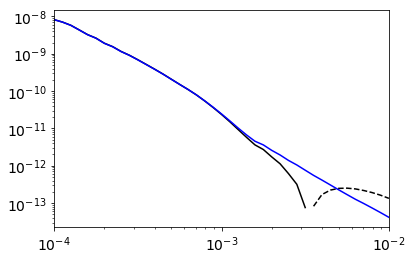

In [31]:
plt.loglog(rx.times, -data_approx, 'k-')
plt.loglog(rx.times, data_approx, 'k--')
plt.loglog(rx.times, -data_em, 'b-')
plt.xlim(1e-4, 1e-2)

(0.0001, 0.01)

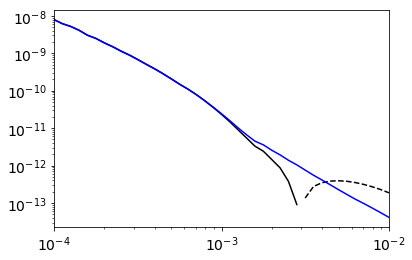

In [14]:
plt.loglog(rx.times, -data_approx, 'k-')
plt.loglog(rx.times, data_approx, 'k--')
plt.loglog(rx.times, -data_em, 'b-')
plt.xlim(1e-4, 1e-2)